In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Normalization
from keras import Input
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input
from keras.applications import Xception
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers

from google.colab import files, drive
import h5py
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pathlib
from random import randint
%matplotlib inline

drive.mount("/content/drive")

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name) +",  tf version: "+str(tf.__version__))

Mounted at /content/drive
Found GPU at: /device:GPU:0,  tf version: 2.4.1


**Download and load datasets**

In [ ]:
main_dir = "../root/.keras/datasets/"
csv_dir = "/content/drive/My Drive/Colab Notebooks/"

if not(os.path.isdir("../root/.keras/datasets/MURA-v1.1")):
  tf.keras.utils.get_file("mura", "https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip", extract=True, archive_format='zip')

df = pd.read_csv(csv_dir+"train_image_data.csv",names=["path","label"])
df.label = df.label.apply(str)
dfv = pd.read_csv(csv_dir+"valid_image_data.csv",names=["path","label"])

3380248576/3380245855 [==============================] - 237s 0us/step


**Loading Validation dataset**

In [ ]:
img_height = 224
img_width = 224

def getImagesInArray(df):
    images = []
    labels = []
    for i, data in tqdm(df.iterrows()):
      img = tf.keras.preprocessing.image.load_img(main_dir+data['path'],color_mode='rgb',target_size=(img_height,img_width))
      img = keras.preprocessing.image.img_to_array(img,dtype="float32")
      images.append(img)
      labels.append(data['label'])
    images = np.asarray(images)
    labels = np.asarray(labels)
    return {'images': images, 'labels': labels}

# train_dict = getImagesInArray(df)
valid_dict = getImagesInArray(dfv)

3197it [00:11, 274.12it/s]


**Validation Data summary and visualisation**

Number of validation images: 3197
Shape of validation images: (3197, 224, 224, 3)
min and max pixel values :  0.0   255.0
mean and std of pixel values :  51.439995   45.62062


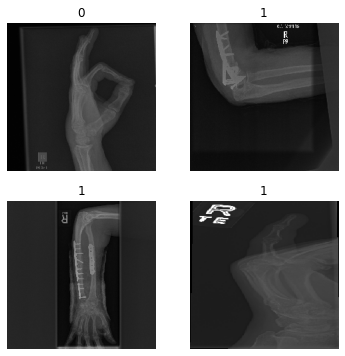

In [ ]:
# print("Number of training images: %d"%(df.shape[0]))
# img = train_dict["images"]
# label = train_dict["labels"]
# print("Shape of training images: "+str(img.shape))
# print("min and max pixel values :  "+str(np.min(img))+"   "+str(np.max(img)))
# print("mean and std of pixel values :  "+str(np.mean(img))+"   "+str(np.std(img)))
# plt.figure(figsize=(6, 6))
# for i in range(4):
#   j = randint(0,img.shape[0]-1)
#   ax = plt.subplot(2,2,i+1)
#   ax.set_title(str(label[j]))
#   plt.imshow(img[j]* 1./255)
#   plt.axis("off")

print("Number of validation images: %d"%(dfv.shape[0]))
imgv = valid_dict["images"]
labelv = valid_dict["labels"]
print("Shape of validation images: "+str(imgv.shape))
print("min and max pixel values :  "+str(np.min(imgv))+"   "+str(np.max(imgv)))
print("mean and std of pixel values :  "+str(np.mean(imgv))+"   "+str(np.std(imgv)))
plt.figure(figsize=(6, 6))
for i in range(4):
  j = randint(0,imgv.shape[0]-1)
  ax = plt.subplot(2,2,i+1)
  ax.set_title(str(labelv[j]))
  plt.imshow(imgv[j]* 1./255)
  plt.axis("off")

**All HyperParameters**

In [ ]:
# -> img height and width
batch_size = 64 #128
val_batch_size = dfv.shape[0] #1 , 8, 64
rotation_range = 30
brightness_range = None #[0.9,1.2]
preprocessing_function = preprocess_input 
standardisation = False #if false, just rescale

lambd = 0.000001 # [1e-6, 1e-5, 4e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
lr = 0.001 # [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
weights = 'imagenet' # None

opt=  Adam(learning_rate=lr)
loss='binary_crossentropy'
metrics=['acc', 'mse']
epochs = 35
pooling = 'avg'
# -> MODEL Architecure, freezing layers, extra layers

my_callbacks = [
                # ModelCheckpoint(checkpoint_dir, monitor = "val_loss", save_best_only=True, mode="min",options=None),
                # EarlyStopping(monitor="val_loss",min_delta=1e-4,patience=8,verbose=1, mode="min",restore_best_weights=True),
                # ReduceLROnPlateau(monitor="val_loss",min_delta=1e-4, factor=0.1, patience=3, verbose=1, min_lr=0.0001,mode="min")                
                ]

**Preprocessing and Augmentation using KERAS**

In [ ]:
# if standardisation:
#   mean = np.mean(train_dict["images"])
#   std = np.std(train_dict["images"])
#   train_dict["images"] = (train_dict["images"]-mean) / std
#   valid_dict["images"] = (valid_dict["images"]-mean) / std
# else:
#   train_dict["images"] = train_dict["images"] * 1./255
#   valid_dict["images"] = valid_dict["images"] * 1./255

train_gen = ImageDataGenerator(
    rotation_range= rotation_range ,
    brightness_range= brightness_range,
    horizontal_flip= True,
    fill_mode="constant",
    cval=0.0,
    preprocessing_function = preprocessing_function

)
valid_gen = ImageDataGenerator(preprocessing_function = preprocessing_function )

train_iter = train_gen.flow_from_dataframe(df,directory=main_dir,x_col="path",y_col="label",target_size=(img_height,img_width),color_mode="rgb",class_mode="binary", batch_size= batch_size, shuffle=True)
valid_iter = valid_gen.flow(x= valid_dict["images"], y= valid_dict["labels"], batch_size= val_batch_size, shuffle=False)

Found 36808 validated image filenames belonging to 2 classes.


**Augmented Data summary**

(64, 224, 224, 3)
min and max pixel values of the batch :  -1.0   1.0
mean and std of pixel values of the batch :  -0.6089417   0.36591676
---------------------------------------------------------------------
(3197, 224, 224, 3)
min and max pixel values of the batch :  -1.0   1.0
mean and std of pixel values of the batch :  -0.5965506   0.357808


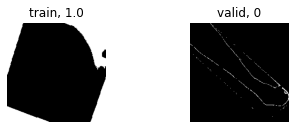

In [ ]:
batch,label = train_iter.next()
print(batch.shape)
print("min and max pixel values of the batch :  "+str(np.min(batch))+"   "+str(np.max(batch)))
print("mean and std of pixel values of the batch :  "+str(np.mean(batch))+"   "+str(np.std(batch)))
j = randint(0,batch.shape[0]-1)
plt.subplot(2,2,1).set_title("train, "+str(label[j]))
plt.imshow(batch[j].astype('uint8'))
plt.axis("off")
print("---------------------------------------------------------------------")
batch,label = valid_iter.next()
print(batch.shape)
print("min and max pixel values of the batch :  "+str(np.min(batch))+"   "+str(np.max(batch)))
print("mean and std of pixel values of the batch :  "+str(np.mean(batch))+"   "+str(np.std(batch)))
j = randint(0,batch.shape[0]-1)
plt.subplot(2,2,2).set_title("valid, "+str(label[j]))
plt.imshow(batch[j].astype('uint8'))
plt.axis("off")

train_iter.reset()
valid_iter.reset()

**define and compile model**

In [ ]:
import tempfile

def add_regularization(model, regularizer):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [ ]:
def define_model():
  base_model = Xception(input_shape=(img_height,img_width,3), weights= weights,include_top= False,pooling= pooling )
  #base_model.trainable : Ans is true
  x = base_model.output
  predictions = Dense(1,activation='sigmoid',name="final")(x) #NOTE: here, not applying l2 reg.
  model = Model(inputs=base_model.input,outputs=predictions)
  return model



model = define_model()
model = add_regularization(model, keras.regularizers.l2(lambd)) #Applying regularisation
model.compile(optimizer=opt, loss = loss, metrics=metrics)
# model.summary()

In [ ]:
#TESTING L2 REG.
model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.00015286884>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00062291033>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0001960799>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0002660303>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0005764156>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00065466296>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.031785e-06>]

**Fit model**

In [ ]:
#verbose for model.evaluate(), validation_split in model.fit
history = model.fit(                        
    train_iter,
    validation_data=valid_iter,
    epochs= epochs,
    workers=1,
    callbacks= my_callbacks
  )
print("\nNo. of epochs ran: %d(expected: %d)"% (len(history.history["val_loss"]), epochs))
# print(history.history)
# model.get_config()

Epoch 1/40
576/576 [==============================] - 752s 1s/step - loss: 0.5547 - acc: 0.7294 - mse: 0.1847 - val_loss: 0.8247 - val_acc: 0.6838 - val_mse: 0.2544
Epoch 2/40
576/576 [==============================] - 730s 1s/step - loss: 0.4779 - acc: 0.7851 - mse: 0.1541 - val_loss: 0.6867 - val_acc: 0.6794 - val_mse: 0.2354
Epoch 3/40
576/576 [==============================] - 723s 1s/step - loss: 0.4526 - acc: 0.7984 - mse: 0.1447 - val_loss: 0.6679 - val_acc: 0.7094 - val_mse: 0.2189
Epoch 4/40
576/576 [==============================] - 716s 1s/step - loss: 0.4435 - acc: 0.8059 - mse: 0.1409 - val_loss: 0.5106 - val_acc: 0.7657 - val_mse: 0.1657
Epoch 5/40
576/576 [==============================] - 722s 1s/step - loss: 0.4283 - acc: 0.8131 - mse: 0.1352 - val_loss: 0.5283 - val_acc: 0.7638 - val_mse: 0.1718
Epoch 6/40
576/576 [==============================] - 718s 1s/step - loss: 0.4189 - acc: 0.8201 - mse: 0.1318 - val_loss: 0.6643 - val_acc: 0.6966 - val_mse: 0.2204
Epoch 7/40

In [ ]:
#TESTING L2 REG.
model.losses

**Prediction stats:**

In [ ]:
valid_dict["images"] = preprocess_input(valid_dict['images'])

Prediction Error:
0.1954957772912105
cohen kappa score:
0.6043253367034204
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1667
           1       0.89      0.67      0.77      1530

    accuracy                           0.80      3197
   macro avg       0.82      0.80      0.80      3197
weighted avg       0.82      0.80      0.80      3197

Confusion Matrix:


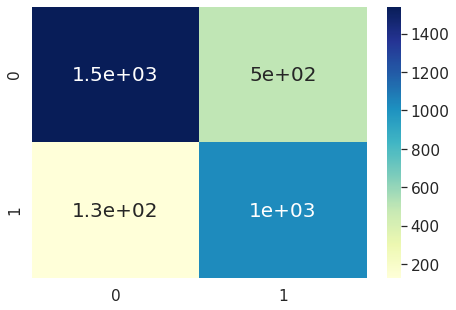

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
#prediction error:
pred_batch = model.predict(valid_dict["images"])
pred = []
for p in pred_batch:
    if(p > 0.5):
        pred+=[1]
    else:
        pred+=[0]
error = np.sum(np.not_equal(pred, valid_dict['labels'])) / valid_dict['labels'].shape[0]  
print("Prediction Error:\n"+str(error))
#cohen kappa:
kap = cohen_kappa_score(valid_dict['labels'] , pred)
print("cohen kappa score:\n"+str(kap))
#Classification Report:
print('Classification Report:')
print(classification_report(valid_dict['labels'], pred, target_names=["0","1"]))
#Confusion Matrix
print('Confusion Matrix:')
import seaborn as sn
cm = confusion_matrix( pred ,valid_dict['labels'])
plt.figure(figsize = (7.5,5))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

**Learning curves**

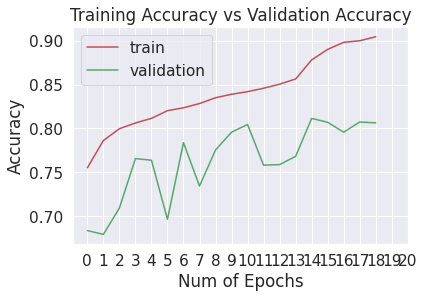

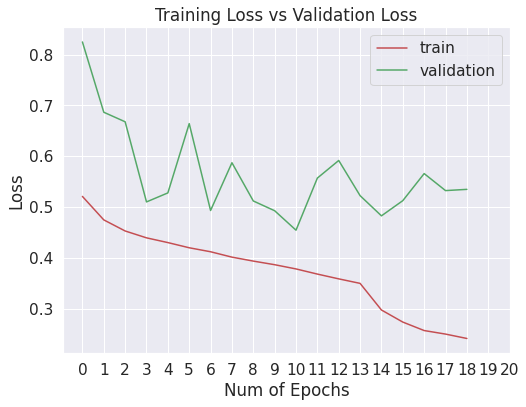

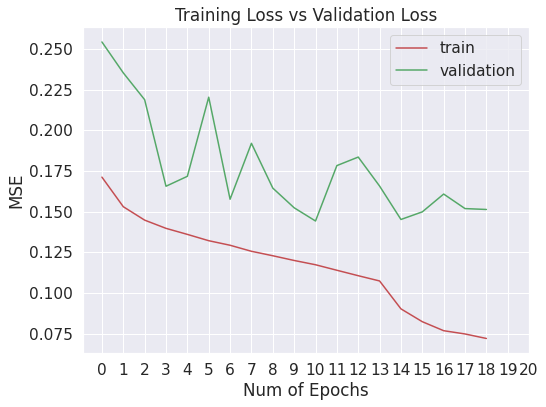

In [ ]:
#Now we have trained our model, we can see the metrics during the training proccess
plt.figure(0)
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'g')
plt.xticks(np.arange(0, 21, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 21, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.figure(2)
plt.plot(history.history['mse'],'r')
plt.plot(history.history['val_mse'],'g')
plt.xticks(np.arange(0, 21, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

**ROC Curve**

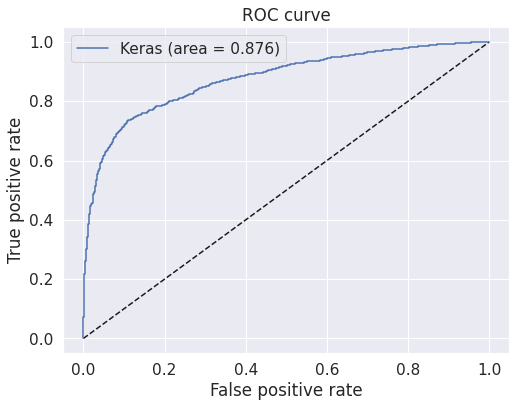

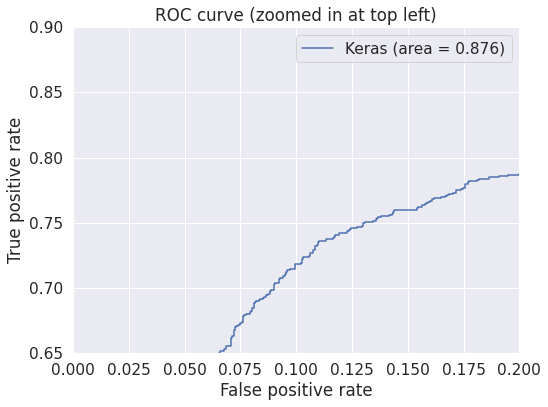

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.2)
plt.ylim(0.65, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

**Visualizing the model**

In [ ]:
# from keras.utils import plot_model 
# from keras.utils.vis_utils import *
# import keras
# import importlib
# importlib.reload(keras.utils.vis_utils)
# import pydot

# plot_model(model, to_file= None, show_shapes=True)

**Save model**

In [ ]:
# save_dir = main_dir+"savedModels/"+"savedModel_"+study_type
# keras.models.save_model(model,save_dir)
# !zip -r ../savedModels.zip ../root/.keras/datasets/savedModels
# files.download("../savedModels.zip")

save_dir_h5 = csv_dir+"XceptionModel-.h5"
keras.models.save_model(model,save_dir_h5,save_format='h5')

# files.download("../root/.keras/datasets/savedModels/saved_model_XR_FINGER.h5")
# files.download(main_dir+study_type+".png")